In [2]:
import numpy as np

In [14]:
def backward_predictor(data,window_width):
    """
    Calculate the backward prediction based on data. https://doi.org/10.1016/0165-0270(91)90118-J
    """
    output = list()
    len_data = len(data)
    for i in range(len_data-1):
        if i+window_width<len_data: 
            prediction = 1/window_width*np.sum(data[i+1:i+1+window_width])
        else:
            prediction = 1/(len_data-i-1)*np.sum(data[i+1:])
        output.append(prediction)
    output.append(data[-1])
    return output

In [15]:
def calculate_forward_weights(data, M, forward_prediction, p):
    """
    Calculate the weight of the forward predictor.
    """
    #predictors should be given as lists, if the first element of forward_prediction is not a list
    #it is assumed that only a single forward prediction was given
    if type(forward_prediction[0]) is not list:
        forward_prediction=[forward_prediction]
    
    len_data = len(data)
    n_predictors = len(forward_prediction)
    #allocate weight array
    f = np.zeros((n_predictors,len_data))

    for i, prediction in enumerate(forward_prediction):
        for k in range(len_data):
            for j in range(M):
                if not k-j<0:
                    f[i,k] += (data[k-j]-prediction[k-j])**2
            #zero should only occur at the beginning, in order to avoid infinities it is replaced by one
            if f[i,k]==0: f[i,k]=1
            f[i,k] = f[i,k]**-p
    return f

In [30]:
def calculate_backward_weights(data, M, backward_prediction, p):
    """
    Calculate the weight of the forward predictor.
    """
    #predictors should be given as lists, if the first element of backward_prediction is not a list
    #it is assumed that only a single backward prediction was given
    if type(backward_prediction[0]) is not list:
        backward_prediction=[backward_prediction]
    
    len_data = len(data)
    n_predictors = len(backward_prediction)
    #allocate weight array
    b = np.zeros((n_predictors,len_data))

    for i, prediction in enumerate(backward_prediction):
        for k in range(len_data):
            for j in range(M):
                if not k+j>=len_data:
                    b[i,k] += (data[k+j]-prediction[k+j])**2
            #zero should only occur at the beginning, in order to avoid infinities it is replaced by one
            if b[i,k]==0: b[i,k]=1
            b[i,k] = b[i,k]**-p
    return b

In [22]:
def test_forward_pred():
    #input
    x = np.array([1,2,3,5,6,8,10,12,14,20,10,15,2,3,5,18,14,12,14])
    #targets
    tp2 = 1/2*np.array([2,2,3,5,8,11,14,18,22,26,34,30,25,17,5,8,23,32,26])
    tp3 = 1/3*np.array([3,3,4,6,10,14,19,24,30,36,46,44,45,27,20,10,26,37,44])
    p2 = forward_predictor(x,2)
    p3 = forward_predictor(x,3)
    assert np.allclose(tp2,p2)
    assert np.allclose(tp3,p3)

In [ ]:
def forward_predictor(data,window_width):
    """
    Calculate the forward prediction based on data. https://doi.org/10.1016/0165-0270(91)90118-J
    """
    output = [data[0]] # Leere Liste wird erstellt, da wir diese nach und nach befüllen.
    for i in range(1,len(data)): # range gibt uns nach und nach die Indices [0, N-1], wo N die Länge der Daten ist. 
        if i-window_width>=0: 
            prediction = 1./window_width*np.sum(data[i-window_width:i])
        else:
            prediction = 1./i*np.sum(data[:i])
        output.append(prediction)
    return output

In [17]:
def test_forward_pred():
    #input
    x = np.array([1,2,3,5,6,8])
    #targets
    tp2 = 1/2*np.array([2,2,3,5,8,11])
    
    tp3 = 1/3.*np.array([3,3,4,6,10,14])
    p2 = forward_predictor(x,2)
    p3 = forward_predictor(x,3)
    print(p3)
    assert np.allclose(tp2, p2)
    assert np.allclose(tp3, p3)
test_forward_pred()

[1, 1.0, 1.5, 2.0, 3.333333333333333, 4.6666666666666661]


AssertionError: 

In [24]:
def test_forward_pred():
    #input
    x = np.array([1,2,3,5,6,8,1,1,1,1,2,3,5,6,8])
    
    tp3 = 1/3.*np.array([3,3,4,6,10,14,19,15,10,3,3,4,6,10,14])

    p3 = forward_predictor(x,3)
    print(p3)
    assert np.allclose(tp3, p3)
test_forward_pred()

[1, 1.0, 1.5, 2.0, 3.333333333333333, 4.6666666666666661, 6.333333333333333, 5.0, 3.333333333333333, 1.0, 1.0, 1.3333333333333333, 2.0, 3.333333333333333, 4.6666666666666661]


AssertionError: 

In [89]:
class ChungKennedyFilter:
    def __init__(self, window_lengths, weight_exponent, weight_window, apriori_f_weights=False, 
                 apriori_b_weights=False):
        self.window_lengths = window_lengths
        self.weight_exponent = weight_exponent
        self.weight_window = weight_window
        n_predictors = len(window_lengths)
        
        if apriori_f_weights: self.apriori_f_weights = apriori_f_weights
        else: self.apriori_f_weights = np.ones(n_predictors)/n_predictors
            
        if apriori_b_weights: self.apriori_b_weights = apriori_b_weights
        else: self.apriori_b_weights = np.ones(n_predictors)/n_predictors
        
        
    def predict_forward(self,data,window_width):
        """
        Calculate the forward prediction based on data. https://doi.org/10.1016/0165-0270(91)90118-J
        """
        output = [data[0]] # Leere Liste wird erstellt, da wir diese nach und nach befüllen.
        for i in range(1,len(data)): # range gibt uns nach und nach die Indices [0, N-1], wo N die Länge der Daten ist. 
            if i-window_width>=0: 
                prediction = 1/window_width*np.sum(data[i-window_width:i])
            else:
                prediction = 1/i*np.sum(data[:i])
            output.append(prediction)
        return output

    def predict_backward(self,data,window_width):
        """
        Calculate the backward prediction based on data. https://doi.org/10.1016/0165-0270(91)90118-J
        """
        output = list()
        len_data = len(data)
        for i in range(len_data-1):
            if i+window_width<len_data: 
                prediction = 1/window_width*np.sum(data[i+1:i+1+window_width])
            else:
                prediction = 1/(len_data-i-1)*np.sum(data[i+1:])
            output.append(prediction)
        output.append(data[-1])
        return output

    def calculate_forward_weights(self, data, forward_prediction):
        """
        Calculate the weight of the forward predictor.
        """
        #predictors should be given as lists, if the first element of forward_prediction is not a list
        #it is assumed that only a single forward prediction was given
        if type(forward_prediction[0]) is not list:
            forward_prediction=[forward_prediction]

        len_data = len(data)
        n_predictors = len(forward_prediction)
        #allocate weight array
        f = np.zeros((n_predictors,len_data))

        for i, prediction in enumerate(forward_prediction):
            for k in range(len_data):
                for j in range(self.weight_window):
                    if not k-j<0:
                        f[i,k] += (data[k-j]-prediction[k-j])**2
                #zero should only occur at the beginning, in order to avoid infinities it is replaced by one
                if f[i,k]==0: f[i,k]=1
                f[i,k] = f[i,k]**-self.weight_exponent
            f[i]*=self.apriori_f_weights[i]
        return f

    def calculate_backward_weights(self, data, backward_prediction):
        """
        Calculate the weight of the forward predictor.
        """
        #predictors should be given as lists, if the first element of backward_prediction is not a list
        #it is assumed that only a single backward prediction was given
        if type(backward_prediction[0]) is not list:
            backward_prediction=[backward_prediction]

        len_data = len(data)
        n_predictors = len(backward_prediction)
        #allocate weight array
        b = np.zeros((n_predictors,len_data))

        for i, prediction in enumerate(backward_prediction):
            for k in range(len_data):
                for j in range(self.weight_window):
                    if not k+j>=len_data:
                        b[i,k] += (data[k+j]-prediction[k+j])**2
                #zero should only occur at the beginning, in order to avoid infinities it is replaced by one
                if b[i,k]==0: b[i,k]=1
                b[i,k] = b[i,k]**-self.weight_exponent
            b[i]*=self.apriori_b_weights[i]
        return b
    
    def calculate_prediction(self, data):
        """
        Generate the final prediction of the Chung Kennedy filter
        """
        forward_predictions = list()
        backward_predictions = list()
        for window in self.window_lengths:
            forward_predictions.append(self.predict_forward(data,window))
            backward_predictions.append(self.predict_backward(data,window))
        
        forward_weights = self.calculate_forward_weights(data, forward_predictions)
        backward_weights = self.calculate_backward_weights(data, backward_predictions)
        
        sum_weights = np.sum(forward_weights,axis=0)+np.sum(backward_weights,axis=0)
        forward_weights/=sum_weights
        backward_weights/=sum_weights
        
        forward_predictions = np.asarray(forward_predictions)
        backward_predictions = np.asarray(backward_predictions)

        print(np.mean(forward_weights))
        print(np.mean(forward_predictions))
        print(np.mean(backward_weights))
        print(np.mean(backward_predictions))

        output = forward_weights*forward_predictions+backward_weights*backward_predictions
        output = np.sum(output,axis=0)
        return output

In [45]:
from recording import Recording

In [109]:
data = Recording('data/180426 000 Copy Export.mat',4e4)

In [122]:
data.baseline_correction()
trace = data['BC_'][20].trace

In [123]:
ckf = ChungKennedyFilter([20,40,100],2,14)

In [146]:
x = ckf.calculate_prediction(x)

0.167592853188
-4.88170871086e-13
0.165740480145
-4.87847015834e-13


In [125]:
import matplotlib.pyplot as plt

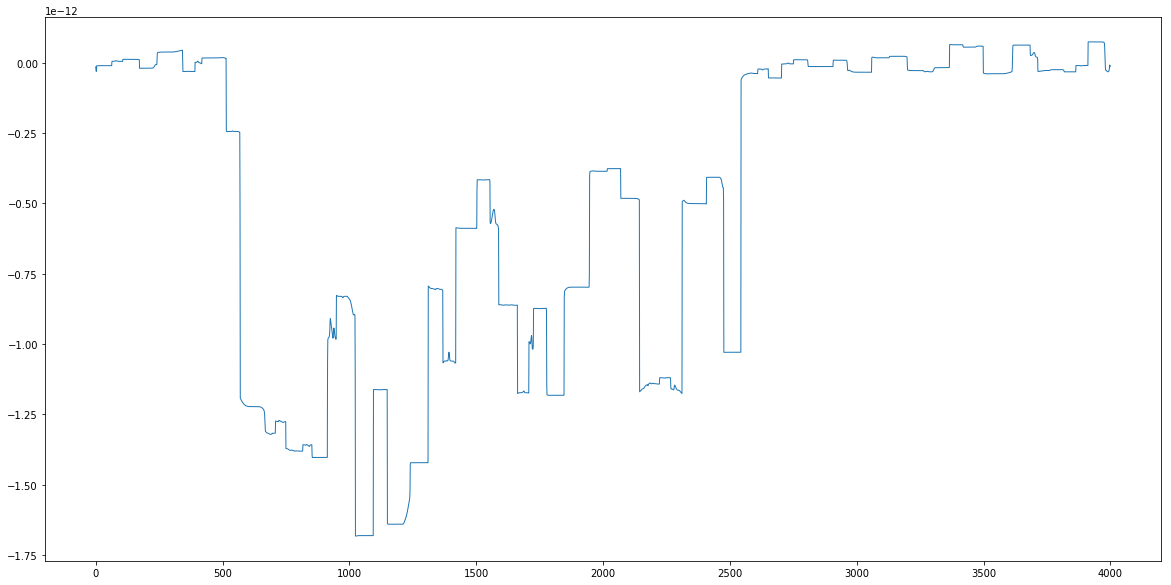

In [147]:
plt.figure(figsize=(20,10))
plt.plot(x,lw=1)
plt.show()

In [127]:
from analysis import multilevel_threshold, threshold_crossing

In [135]:
amps = -1e-12*np.array([.2,.35,.5,.9])
i = multilevel_threshold(trace,[.1,.3,.55,.85])

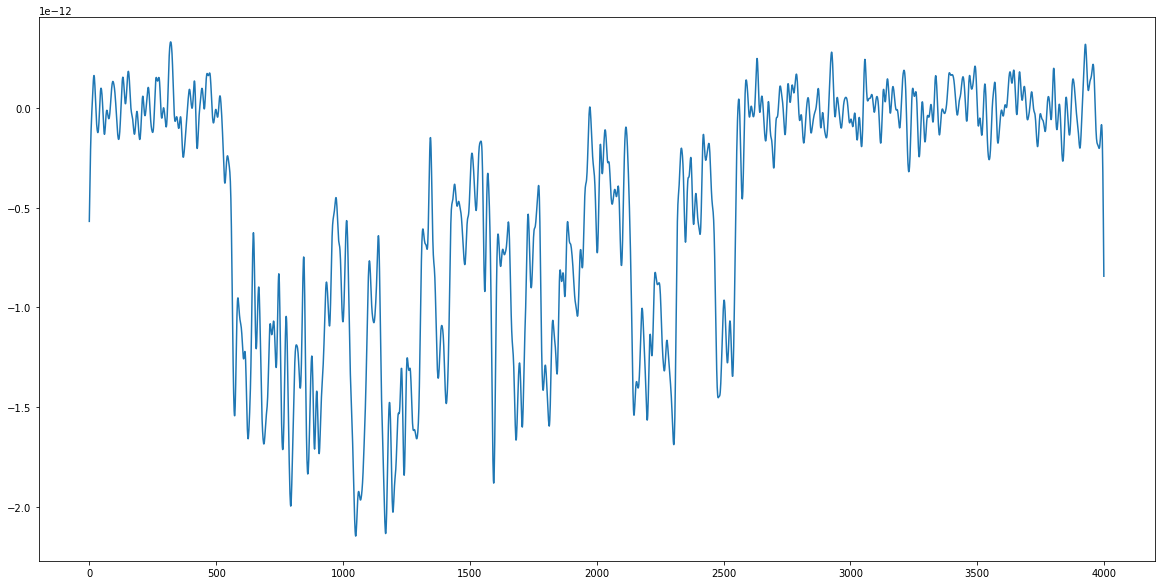

In [139]:
plt.figure(figsize=(20,10))
plt.plot(data['BC_BC_GFILTER1000.0_'][20].trace)
plt.show()

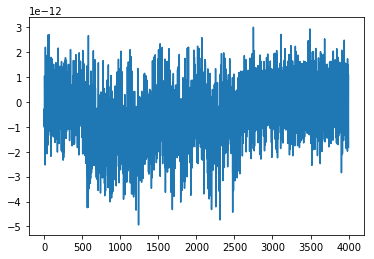

In [130]:
plt.plot(trace)
plt.show()

In [131]:
data.gauss_filter_series(1e3)

True

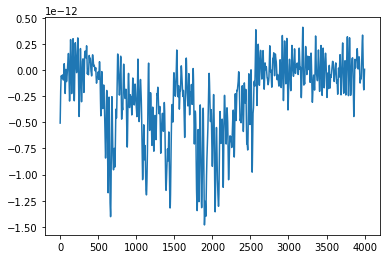